- 背景说明

随着人们生活水平的提高，越来越多的人们选择假期旅游，然而节假日大量的人员流动造成了热门景点附近的地铁站人员密集，若遇突发情况，人员无法有效疏散。在此背景下，通过对地铁站人流量数据进行分析，推测出人员密集区域和高峰时段，从而提前做好准备，为合理疏导人群、规避交通堵塞提供预警服务。

- 数据样例

&emsp;&emsp;1、`data.csv` 包含 `2022-01-01.csv` 至`2022-01-10.csv`共`20天`的地铁站数据，共`20万`条。

| 列名 | 类型 | 说明 | 示例 |
| ---- | ---- | ---- | ---- |
| time | String | 刷卡发生时间 | 2022-01-01 02:00:05 |
| lineID | String | 地铁线路ID | B |
| stationID | int | 地铁站ID | 27 |
| deviceID | int | 刷卡设备编号ID | 1354 |
| status | int | 进出站状态，0为出站，1为进站 | 0 |
| userID | String | 用户身份ID | D13f76f42c9a677c4add94d9e480fb5c5 |
| payType | int | 用户刷卡类型 | 3 |

&emsp;&emsp;2、`Metro_roadMap.csv` 是一个81x81的二维矩阵。文件中首行和首列表示地铁站ID（stationID），columns为0-80，rows为0-80。roadMap[i][j] = 1 表示stationID为i的地铁站和stationID为j的地铁站直接相连；roadMap[i][j] = 0 表示stationID为i的地铁站和stationID为j的地铁站不相连。
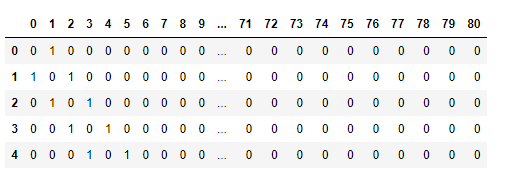

- 分析思路

&emsp;&emsp;1.对数据整体进行观察。由于数据中存在不合法的数据，如：0点后仍有刷卡记录以及一些值为NaN的数据等，将这类数据进行剔除。对清洗后的数据进行统计。<br>

&emsp;&emsp;2.分析线路、站点、设备之间的关系。利用分组聚合，分析线路、站点、设备之间的数量关系，并使用matplotlib进行可视化分析。<br>
&emsp;&emsp;3.分析用户、刷卡类型、时间段之间的关系。利用分组聚合，分析每个时间段的用户数量，并可视化，以便于查看什么时间亦或哪条线路用户进出站达到峰值。<br>
&emsp;&emsp;4.分析地铁站点在三条线路的分布情况。利用分组聚合，以线路A为例，对1月1日至1月20日共计20天内的地铁站点（站67到站80）人流量进行分析，并使用饼状图对每个站点的情况进行展示。<br>
&emsp;&emsp;5.按时间段分析线路A、B、C各站的人流量情况。利用分组聚合的方式统计 `早高峰[7:00-9:00]` 和 `晚高峰[17:00-20:00]`的进出站人数，并利用pyecharts库进行地图可视化。<br>

# 0、导包

- 导入数据分析所用的第三方库：`numpy、pandas、matplotlib`；

- 为了防止`matplotlib`画图例时中文乱码情况，下面给出 `2种` 解决方案：

- 第一种：

    - -  &emsp;1、第一步：安装mplfonts库

    - - &emsp;`!pip install mplfonts -i https://pypi.tuna.tsinghua.edu.cn/simple` 

    - -  &emsp;2、第二步：添加下列代码： 

    - - `from mplfonts import use_font`
    - - `use_font('Noto Serif CJK SC')#指定中文字体`
    
- 第二种：
    - -  &emsp;1、升级matplotlib
    - -  &emsp;2、写入如下代码
    - - &emsp;`# 设置显示中文字体，# 设置font.sans-serif 或 font.family 均可
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"] ## mac
plt.rcParams['font.family']=['Arial Unicode MS'] ## mac
plt.rcParams["font.sans-serif"] = ["SimHei"] ## win
plt.rcParams['font.family']=['SimHei'] ## win
plt.rcParams["axes.unicode_minus"] = False # 设置正常显示符号`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 设置显示中文字体，
# 设置font.sans-serif 或 font.family 均可
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"] ## mac
plt.rcParams['font.family']=['Arial Unicode MS'] ## mac
plt.rcParams["font.sans-serif"] = ["SimHei"] ## win
plt.rcParams['font.family']=['SimHei'] ## win
# 设置正常显示符号
plt.rcParams["axes.unicode_minus"] = False

# 1、数据观察

- 查看数据样本信息，如一条数据样本中包含哪些属性；
- 查看数据类型，判断是否需要转换数据格式；
- 查看数据是否有缺失、无效等情况，若有则对数据进行清洗；

## 1.1 观察数据

In [2]:
dataPath = './data/data.csv'
df = pd.read_csv(dataPath)
df.head() #查看数据样式

,time,lineID,stationID,deviceID,status,userID,payType
0,2022-01-01 14:34:23,B,19,1006,1,Cff263245447d6ad1fbc2c6166582234e,2
1,2022-01-01 18:35:52,C,47,2271,1,A27aff32d8340333a616d62e12434ccbe,0
2,2022-01-01 19:35:45,B,17,952,1,Bedb7c79d26ae95c2a9f14b51b3797ed8,1
3,2022-01-01 21:00:03,B,27,1351,1,Cb32ccd5e11669b4c7c5e59fc3ffe7dba,2
4,2022-01-01 15:47:29,B,0,0,0,D964f8837a1a6326d0fe6bb36457874de,3


In [3]:
# 查形状
df.shape

(200000, 7)

In [4]:
# 查缺省
df.isnull()

,time,lineID,stationID,deviceID,status,userID,payType
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
199995,False,False,False,False,False,False,False
199996,False,False,False,False,False,False,False
199997,False,False,False,False,False,False,False
199998,False,False,False,False,False,False,False


In [5]:
# 查看数据类型
df.dtypes

time         object
lineID       object
stationID     int64
deviceID      int64
status        int64
userID       object
payType       int64
dtype: object

In [6]:
df.describe()

,stationID,deviceID,status,payType
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,32.335170,1552.001955,0.499205,1.383740
std,23.208249,1061.014492,0.500001,0.844498
min,0.000000,0.000000,0.000000,0.000000
25%,12.000000,641.000000,0.000000,1.000000
50%,25.000000,1273.000000,0.000000,1.000000
75%,52.000000,2533.000000,1.000000,2.000000
max,80.000000,3638.000000,1.000000,3.000000


### 结论

- lineID的范围是{A, B, C}，有 3 条线路
- staionID的范围是[0，80]，有81个站点
- deviceID的范围是[0,3638]，有3639个刷卡设备
- status的范围是{0,1}，0为出站，1为进站
- payType的范围是{0,1,2,3}

## 1.2 数据类型转换

- 1、`time` 列为方便后面计算，修改为可计算类型'datetime'
- 2、`time` 列为方便后面计算，将原始数据 `2022-01-01 14:34:23` 拆成 `2022-01-01` 和 `14:34:23` 两列

In [7]:
# 将 time 列 转换成 datetime类型
df['time'] = pd.to_datetime(df['time'])
df.head()
df.dtypes

time         datetime64[ns]
lineID               object
stationID             int64
deviceID              int64
status                int64
userID               object
payType               int64
dtype: object

In [8]:
# 将 time 列中的 年月日 提取出来 填入 date1 

df['date1'] = pd.to_datetime(df['time'],format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d')
df.head()

,time,lineID,stationID,deviceID,status,userID,payType,date1
0,2022-01-01 14:34:23,B,19,1006,1,Cff263245447d6ad1fbc2c6166582234e,2,2022-01-01
1,2022-01-01 18:35:52,C,47,2271,1,A27aff32d8340333a616d62e12434ccbe,0,2022-01-01
2,2022-01-01 19:35:45,B,17,952,1,Bedb7c79d26ae95c2a9f14b51b3797ed8,1,2022-01-01
3,2022-01-01 21:00:03,B,27,1351,1,Cb32ccd5e11669b4c7c5e59fc3ffe7dba,2,2022-01-01
4,2022-01-01 15:47:29,B,0,0,0,D964f8837a1a6326d0fe6bb36457874de,3,2022-01-01


In [9]:
# 将 time 列中的 时分秒 提取出来 填入 date2 列

df['date2'] = pd.to_datetime(df['time'],format='%Y-%m-%d %H:%M:%S').dt.strftime('%H:%M:%S')
df.head()

,time,lineID,stationID,deviceID,status,userID,payType,date1,date2
0,2022-01-01 14:34:23,B,19,1006,1,Cff263245447d6ad1fbc2c6166582234e,2,2022-01-01,14:34:23
1,2022-01-01 18:35:52,C,47,2271,1,A27aff32d8340333a616d62e12434ccbe,0,2022-01-01,18:35:52
2,2022-01-01 19:35:45,B,17,952,1,Bedb7c79d26ae95c2a9f14b51b3797ed8,1,2022-01-01,19:35:45
3,2022-01-01 21:00:03,B,27,1351,1,Cb32ccd5e11669b4c7c5e59fc3ffe7dba,2,2022-01-01,21:00:03
4,2022-01-01 15:47:29,B,0,0,0,D964f8837a1a6326d0fe6bb36457874de,3,2022-01-01,15:47:29


<font size=4 color=#0000dd>将 `time列` 转换成可计算类型datetime类型，并将小时提取出来给到`hours列`</font>

In [10]:
# 第2步：将 time 列 转换成可计算类型
df['hours'] = pd.to_datetime(df['time'],format='%Y-%m-%d %H:%M:%S').dt.hour
df.head()

,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
0,2022-01-01 14:34:23,B,19,1006,1,Cff263245447d6ad1fbc2c6166582234e,2,2022-01-01,14:34:23,14
1,2022-01-01 18:35:52,C,47,2271,1,A27aff32d8340333a616d62e12434ccbe,0,2022-01-01,18:35:52,18
2,2022-01-01 19:35:45,B,17,952,1,Bedb7c79d26ae95c2a9f14b51b3797ed8,1,2022-01-01,19:35:45,19
3,2022-01-01 21:00:03,B,27,1351,1,Cb32ccd5e11669b4c7c5e59fc3ffe7dba,2,2022-01-01,21:00:03,21
4,2022-01-01 15:47:29,B,0,0,0,D964f8837a1a6326d0fe6bb36457874de,3,2022-01-01,15:47:29,15


In [11]:
df.dtypes

time         datetime64[ns]
lineID               object
stationID             int64
deviceID              int64
status                int64
userID               object
payType               int64
date1                object
date2                object
hours                 int64
dtype: object

In [12]:
 # 查形状
df.shape

(200000, 10)

## 1.3 清除异常值

- 假设地铁早上6：00开门，晚上 23：00关门

-  删除符合条件的指定行，并替换原始df

<font size=4 color=#0000dd>删除符合条件的指定行(异常值)，原表也随之改变 </font>

In [13]:
print("原始数据：",df.shape[0])
# 假设地铁早上6：00开门，晚上 23：00关门
D = df[(df['hours'] <= 6) | (df['hours'] >= 23)]
print("异常值：",D.shape[0])

# 删除符合条件的指定行，原表也变
df.drop(df[(df['hours'] <= 6) | (df['hours'] >= 23)].index, inplace=True) 

df.shape

原始数据： 200000
异常值： 4257


(195743, 10)

In [14]:
# 查看地铁矩阵图
import seaborn as sns

road_map = pd.read_csv('./data/Metro_roadMap.csv')
print(road_map.shape) #多了一列Unnamed
road_map = road_map.drop(['Unnamed: 0'],axis=1)
road_map.head(5)

(81, 82)


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


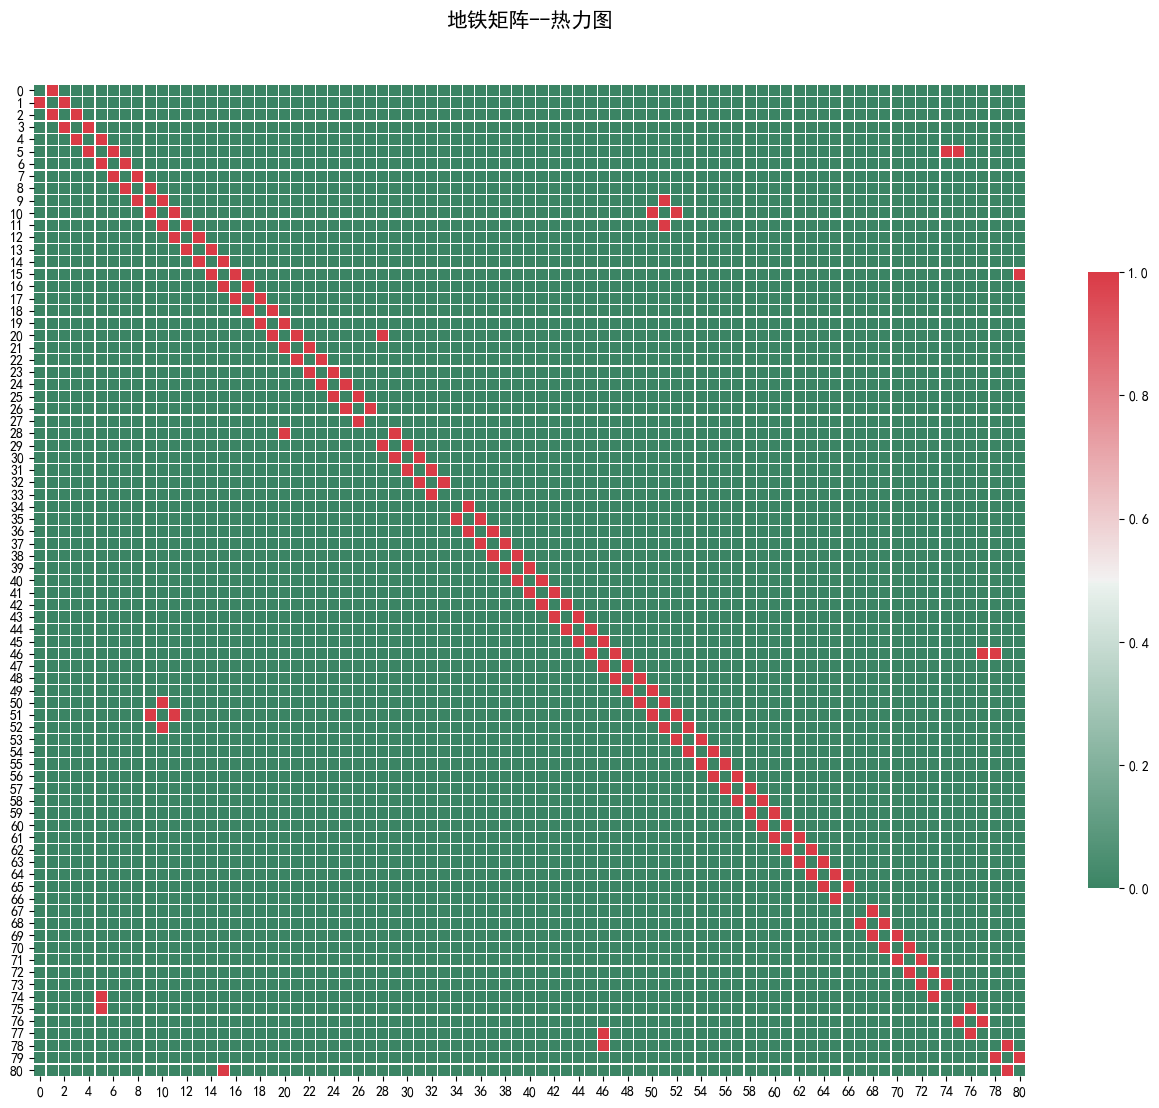

In [15]:
# TODO: 地铁矩阵--热力图
# correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(16, 16))
    colormap = sns.diverging_palette(150, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df, 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.5 }, 
        ax=ax,
        linewidths=0.1,vmax=1.0, linecolor='white',
    )
    
    plt.title('地铁矩阵--热力图', y=1.05, size=15)

correlation_heatmap(road_map)

- 地铁热力图分析

1、中间正对角线方向可以发现i,j相连表现的是上下站的连接  (参考：roadMap[i][j] = 1 表示stationID为i的地铁站和stationID为j的地铁站直接相连；roadMap[i][j] = 0 表示stationID为i的地铁站和stationID为j的地铁站不相连。)<br>
2、其余剩下10个零散点为重点研究对象，可列表统计


| 站点i | 站点j |
| ---- | ---- |
| 28 | 20 |
| 51 | 9 |
| 50 | 10 |
| 51 | 11 |
| 52 | 10 |
| 74 | 5 |
| 75 | 5 |
| 80 | 15 |
| 77 | 46 |
| 78 | 46 |

# 2、线路、站点、设备数分析


- 1、基本统计：线路、站点、设备数的基本情况；
- 2、借助分组聚合，分析每条线路的站点数；
- 3、利用 `groupby` 查看每条线路记录数最多的站点；
- 4、假设：越大的站点设备数越多。比如换乘站和人流密集站点会有多个出口；查看设备数最多的站点

<font size=4 color=#0000dd>绘制地铁线路数值分布图柱状图</font>

LineA记录数: 21139  LineB记录数: 112122  LineC记录数: 62482  

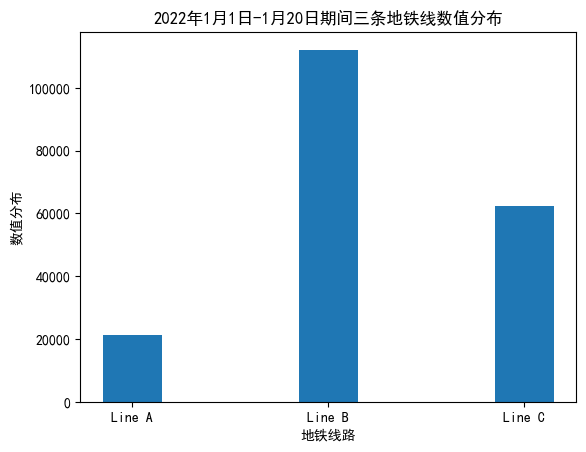

In [16]:
# 每条线路的人流量分布情况
y_A = df[df['lineID'] == 'A'].shape[0]
y_B = df[df['lineID'] == 'B'].shape[0]
y_C = df[df['lineID'] == 'C'].shape[0]

# 打印每条线路的记录总数，作为数值考核
print("LineA记录数:", y_A, end='  ')
print("LineB记录数:", y_B,  end='  ')
print("LineC记录数:", y_C,  end='  ')

x= ['Line A', 'Line B', 'Line C']
y = [y_A, y_B, y_C]


plt.title('2022年1月1日-1月20日期间三条地铁线数值分布')
plt.bar(x, y, width=0.3, label="线路分布")
plt.xlabel("地铁线路")#给x轴起名字
plt.ylabel("数值分布")#给y轴起名字
plt.show()

<font size=4 color=#0000dd>使用seaborn库绘制地铁各个站点压力分布柱状图</font>

15    16001
9      8810
4      5573
7      5489
10     4726
      ...  
35      706
28      672
31      656
72      643
74      523
Name: stationID, Length: 80, dtype: int64


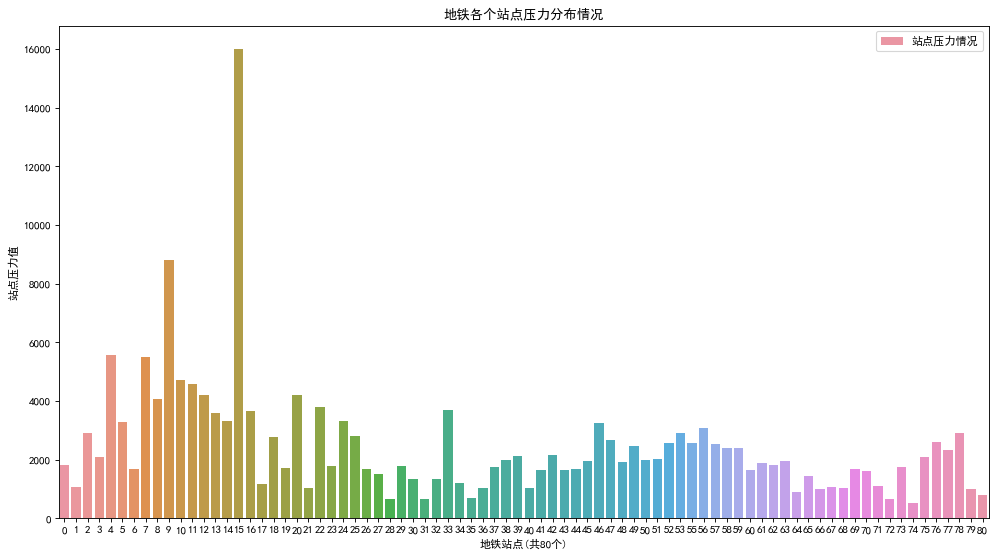

In [18]:
## 绘制条形图：站点压力分布图
number_of_stationID = df.stationID.value_counts()
print(number_of_stationID)

fig = plt.figure(figsize=(15, 8), dpi=80)

plt.title('地铁各个站点压力分布情况')
ax = sns.barplot(x=number_of_stationID.index, y=number_of_stationID, label = "站点压力情况")
text = ax.set_xticklabels(ax.get_xticklabels())

# 给X、Y 轴起名字
plt.ylabel("站点压力值")
plt.xlabel("地铁站点(共80个)")

# 设置图列
plt.legend()

# 显示图片
plt.show()

<font size=5> **小结** </font>

- 1、路线B是最繁忙的，大概11w条记录，占到总量的57%；路线C有6w条左右记录；路线A最少，2w条左右记录
- 2、最繁忙的站点是站点15，1w多条记录，其次是9站点，8810条记录

<font size=4 color=#0000dd>根据 `lineID列` 对 `stationID`进行分组聚合分析</font>

In [63]:
# 通过分组聚合查看每条路线的站点数
df.groupby('lineID')['stationID'].nunique()

lineID
A    14
B    34
C    32
Name: stationID, dtype: int64

<font size=4 color=#0000dd>将列表`LineStation` 转换成 `DataFrame`类型 </font>

In [64]:
# 创建线路与站点关系表
LineStation = [['A',14], ['B',34],['C',32]]
LineStation  =  pd.DataFrame(LineStation, columns=['lineID', 'stationNum'])
LineStation.head()

,lineID,stationNum
0,A,14
1,B,34
2,C,32


<font size=4 color=#0000dd>筛选出`线路ABC`的进出站数据</font>

In [81]:
# 计算每条线路的进出站情况, 0为出站，1为进站
A_status_1 = df[(df['lineID'] == 'A') & (df['status'] == 1.0)].shape[0] # ????.shape[0]
A_status_0 = df[(df['lineID'] == 'A') & (df['status'] == 0.0)].shape[0] # ????.shape[0]


# 筛选线路B的进出站数据
B_status_1 = df[(df['lineID'] == 'B') & (df['status'] == 1.0)].shape[0] # ????.shape[0]
B_status_0 = df[(df['lineID'] == 'B') & (df['status'] == 0.0)].shape[0] # ????.shape[0]


# 筛选线路C的进出站数据
C_status_1 = df[(df['lineID'] == 'C') & (df['status'] == 1.0)].shape[0] # ????.shape[0]
C_status_0 = df[(df['lineID'] == 'C') & (df['status'] == 0.0)].shape[0] # ????.shape[0]


# 数值打印
print("线路A进出站数据：",A_status_1, A_status_0)
print("线路B进出站数据：",B_status_1, B_status_0)
print("线路C进出站数据：",C_status_1, C_status_0)

线路A进出站数据： 10512 10627
线路B进出站数据： 55899 56223
线路C进出站数据： 30966 31516


<font size=4 color=#0000dd>绘制三条线路的进出站情况(柱状图) </font>

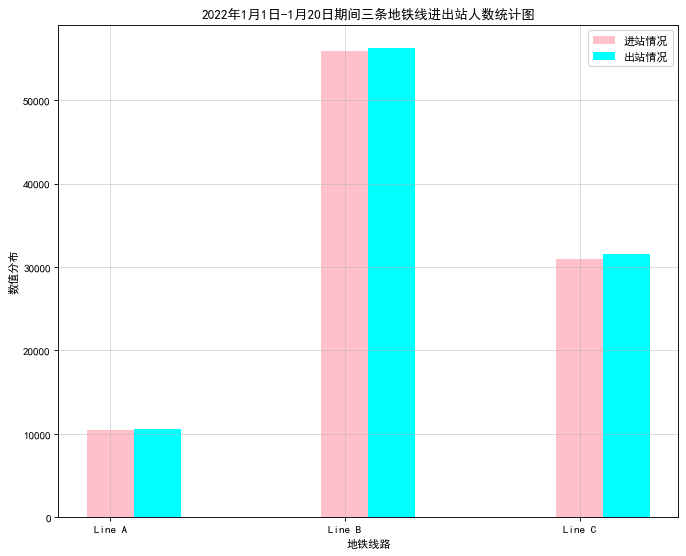

In [149]:
# 画出三条线路的进出站情况图
x = ['Line A', 'Line B', 'Line C']

y_1 = [A_status_1, B_status_1, C_status_1] # 进站数据
y_2 = [A_status_0, B_status_0, C_status_0] # 出站数据


# 一个柱状图画完之后，往x轴左移
bar_width = 0.2  # 设置柱状图大小不能超过0.3
x_1 = list(range(len(x)))
x_2 = [i + bar_width for i in x_1]


# 设置图片大小
fig = plt.figure(figsize=(10, 8), dpi=80)

# 设置网格
plt.grid(alpha=0.5)
plt.title('2022年1月1日-1月20日期间三条地铁线进出站人数统计图')

# 绘制三条地铁线进出站人数柱状图
plt.bar(range(len(x)), y_1, width=bar_width, color= '#FFC0CB', label = "进站情况")
plt.bar(x_2,y_2, width=bar_width, color= '#00FFFF', label = "出站情况")

#给x、y轴起名字
plt.xlabel("地铁线路")
plt.ylabel("数值分布")

# 设置图列
plt.legend()

# 调整x轴
plt.xticks(range(len(x)), x)

# 显示图片
plt.show()

<font size=5> **小结** </font>

- 1、根据分析结果可知，线路A有 `14个` 地铁站点，线路B有 `34个` 地铁站点，线路C有 `32个` 地铁站点；
- 2、根据图示结果，可以很清晰的发现，线路B的进出站压力相较于A和C较大，可以考虑在线路B上增设地铁站点。

In [87]:
# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)
# 查看每条路线各站点记录数
df.groupby('lineID')['stationID'].count()

lineID
A     21139
B    112122
C     62482
Name: stationID, dtype: int64

In [88]:
# 假设：越大的站点设备数越多。比如换乘站和人流密集站点会有多个出口
# 查看各站点设备刷卡记录数
pd.set_option('display.max_rows', None)
df.groupby('deviceID')['time'].count()

deviceID
0       176
1       186
2       205
3       264
4       162
5        85
6        52
7        15
8        15
9        10
10       24
11       61
12       76
13      169
14       78
15       91
16       83
17       64
42      105
43      113
44      137
45      252
46      150
47       76
48      104
49       16
50       13
51       51
52       19
53       25
54       12
72      405
73      421
74      383
75      441
76      316
77      203
78      116
79       72
80      103
81      119
82       82
83       84
84       80
85       77
106     138
107     196
108     188
109     219
110     347
111     213
112     138
113      83
114      41
115      76
116     143
117      94
118     118
119      88
137      43
138      53
139      89
140      89
141     147
142     291
143     192
144     159
145     152
146     192
147     128
148     113
149     103
150     129
151     109
152     135
153     224
154     332
155     440
156     598
157     306
158     301
159     264
160    

In [89]:
# 查看各站点设备数
df.groupby('stationID')['deviceID'].nunique()

stationID
0     18
1     13
2     14
3     14
4     28
5     43
6     17
7     26
8     32
9     31
10    20
11    21
12    25
13    14
14    18
15    67
16    44
17    13
18    13
19    14
20    37
21    14
22    21
23    14
24    21
25    28
26    21
27    20
28    17
29    21
30    21
31    15
32    15
33    20
34    19
35    14
36    14
37    15
38    15
39    19
40    11
41    19
42    19
43    26
44    23
45    27
46    41
47    22
48    16
49    25
50    21
51    26
52    25
53    19
55    19
56    19
57    17
58    22
59    27
60    19
61    20
62    21
63    30
64    14
65    24
66    19
67    11
68    16
69    22
70    15
71    13
72    14
73    22
74    14
75    24
76    26
77    26
78    17
79    11
80    14
Name: deviceID, dtype: int64

<font size=5>  **小结** </font>

<font size=4>分析前提：假设越大的站点设备数越多，如换乘站和人流密集站点会有多个出口</font>

- 根据上述分析可得，最繁忙的15、9站点都在路线B上；站点15的设备数有`67`个，后期可以适当增加。

# 3、用户、刷卡类型

- 分析用户ID是否唯一
- 分析同一刷卡类型下，用户分布情况
- 用户当天乘坐地铁情况分析

<font size=4 color=#0000dd>分析不同刷卡类型用户分布情况</font>

In [151]:
# 用户数
print('用户数：',df.userID.nunique())

# 刷卡类型
print('刷卡类型统计：', df.payType.value_counts())

# 刷卡类型用户分布
print('刷卡类型用户分布：', df.groupby('payType')['userID'].nunique())

用户数： 184146
刷卡类型统计： 1    91049
2    58086
0    25637
3    20971
Name: payType, dtype: int64
刷卡类型用户分布： payType
0    23624
1    86210
2    54346
3    19966
Name: userID, dtype: int64


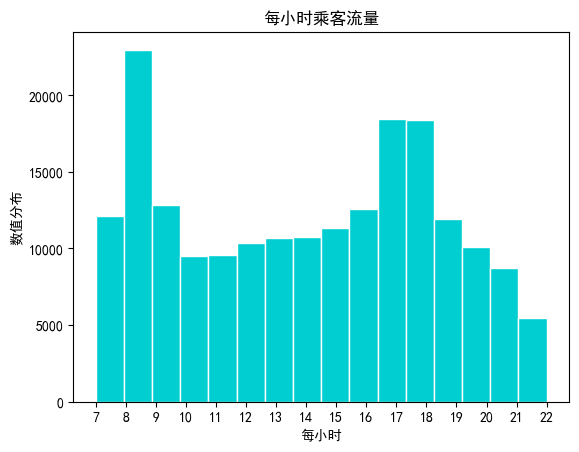

In [96]:
# 绘制直方图
fig = plt.figure()
ax = fig.add_subplot(111)
# plt.grid()  # 设置网格模式
ax.hist(df['hours'], bins=16, color='#00CED1', edgecolor='white')
plt.title('每小时乘客流量')
plt.xlabel('每小时')
plt.ylabel('数值分布')
# 设置坐标轴刻度
x_list = [x for x in range(7,23)]
plt.xticks(x_list)
plt.show()

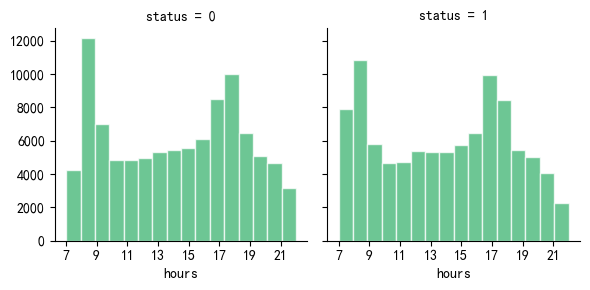

In [97]:
# 根据进出站状态对直方图进行调整
g = sns.FacetGrid(df, col='status')
g.map(plt.hist, 'hours',color= '#3CB371', edgecolor='white', alpha=.75, bins=16)
x_list = [x for x in range(7,23,2)]
plt.xticks(x_list)
plt.show()

<font size=5>  **小结** </font>

- 约有2000条用户ID重复，可能与payTpye = 3有关；
- 根据上述分析可得，早上 `[8:00-9:00]` 以及 晚上 `[17:00-18:00]` 地铁站客流量最大。

# 4、 从时间角度进行分析

- 按天分析，分别对节假日情况、周内情况、周末情况进行分析；
- 按时间段分析，分析各个时段的进出站情况；
- 按早晚高峰分析，假设早高峰是 `7:00-9:00`，晚高峰是 `17:00 - 20:00`。


## 4.1 线路A各个地铁站点压力情况

In [98]:
df2 = df[(df['lineID'] == 'A')]
df2.head()

,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
11,2022-01-01 15:24:45,A,75,3407,0,B18afab4740da695f296e1c9cd509e0ea,1,2022-01-01,15:24:45,15
13,2022-01-01 21:53:26,A,67,3134,0,Bb06e2f019f1ceb6f5417bd0180c6f1f5,1,2022-01-01,21:53:26,21
31,2022-01-01 13:23:24,A,67,3129,1,C00c73dda8ab928d4d3ad05043acdbc10,2,2022-01-01,13:23:24,13
32,2022-01-01 13:13:13,A,74,3381,0,C223eff6d5caac0dd0f41ec9e8b1f8be4,2,2022-01-01,13:13:13,13
39,2022-01-01 12:34:53,A,71,3274,1,Bac588d271ececc273a789e83cf5254af,1,2022-01-01,12:34:53,12


In [101]:
# 对 stationID 进行升序排列
df2 = df2.sort_values(by='stationID', ascending=True)
df2.head(10)

,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
139556,2022-01-14 17:39:07,A,67,3134,0,B07a07235fc42e0ef06f71a934789f5fa,1,2022-01-14,17:39:07,17
100716,2022-01-11 17:29:13,A,67,3122,0,C41b45b48ec2ad2783aa95c29cc764fd5,2,2022-01-11,17:29:13,17
35927,2022-01-04 11:32:09,A,67,3134,0,Dc55e9c3dba76532cfd2895bb47b1a0c4,3,2022-01-04,11:32:09,11
40339,2022-01-05 21:54:01,A,67,3124,0,Bc8fda1cf406356dcddfc27d479b8b939,1,2022-01-05,21:54:01,21
121209,2022-01-13 09:08:38,A,67,3126,1,Bc4b4179a9f35e28949ab03fecbed2625,1,2022-01-13,09:08:38,9
78256,2022-01-08 14:43:21,A,67,3124,0,C885030352e0fbd5ddaa1ed9ba44559bf,2,2022-01-08,14:43:21,14
19599,2022-01-02 17:59:45,A,67,3124,0,A43e59d43bbb96345993f9223d413bd8f,0,2022-01-02,17:59:45,17
117450,2022-01-12 07:04:28,A,67,3126,1,Be690b94ae351b52b165d93381dfdb693,1,2022-01-12,07:04:28,7
3591,2022-01-01 14:46:47,A,67,3125,1,B2256a45a6734053b47e046d1a501e50c,1,2022-01-01,14:46:47,14
78302,2022-01-08 07:14:47,A,67,3125,1,Caaf987dd1abba96feba6415e719faad6,2,2022-01-08,07:14:47,7


In [102]:
# 查看 stationID 中的站点刷卡情况
arr = df2['stationID'].value_counts()
print(arr)

78    2914
76    2611
77    2337
75    2079
73    1734
69    1683
70    1606
71    1108
67    1070
68    1038
79    1009
80     784
72     643
74     523
Name: stationID, dtype: int64


In [103]:
# 根据 arr.index 得出 stationID 中的站点情况，进行数值统计并可视化分析

def Num_stationID(num):
    a = df2[df2['stationID'] == num]
    return a 

# 调用函数求值
x_67 = Num_stationID(67.0)
x_68 = Num_stationID(68.0)
x_69 = Num_stationID(69.0)
x_70 = Num_stationID(70.0)
x_71 = Num_stationID(71.0)
x_72 = Num_stationID(72.0)

x_73 = Num_stationID(73.0)
x_74 = Num_stationID(74.0)
x_75 = Num_stationID(75.0)

x_76 = Num_stationID(76.0)
x_77 = Num_stationID(77.0)

x_78 = Num_stationID(78.0)
x_79 = Num_stationID(79.0)
x_80 = Num_stationID(80.0)

# 将 每个站点的数值情况填入数组 arr2
arr2 = [x_67.shape[0],x_68.shape[0], x_69.shape[0], x_70.shape[0], x_71.shape[0], x_72.shape[0], x_73.shape[0], x_74.shape[0], x_75.shape[0], x_76.shape[0], x_77.shape[0], x_78.shape[0], x_79.shape[0], x_80.shape[0]]
arr2

[1070,
 1038,
 1683,
 1606,
 1108,
 643,
 1734,
 523,
 2079,
 2611,
 2337,
 2914,
 1009,
 784]

<font size=4 color=#0000dd>对A线路各站点人流量（刷卡记录）进行分析，并绘制饼图 </font>

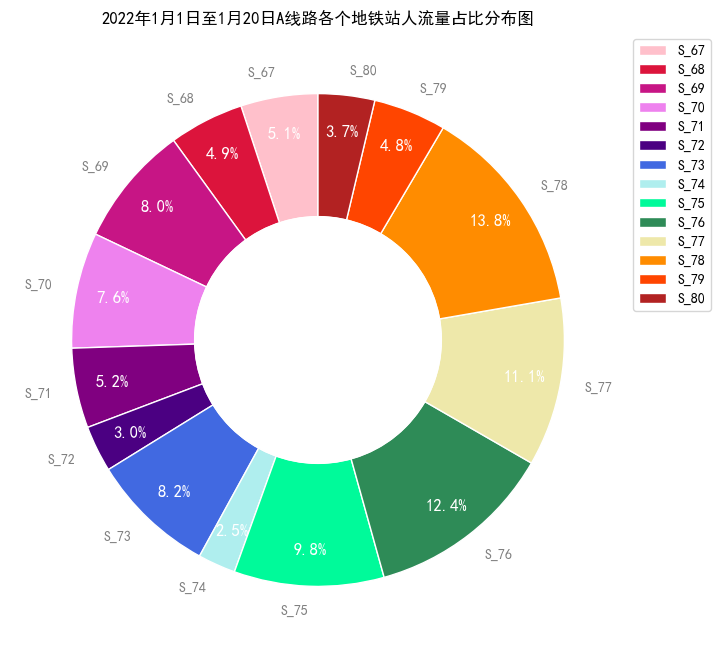

In [106]:
# 根据 arr2中的数值，画出 2022年1月1日至1月20日A线路各个地铁站人流量占比分布图
import matplotlib.pyplot as plt

# 定义数据
labels = ['S_67', 'S_68','S_69','S_70','S_71','S_72','S_73',
         'S_74','S_75','S_76','S_77','S_78','S_79','S_80']
sizes = arr2
colors = ['#FFC0CB', '#DC143C', '#C71585', '#EE82EE', '#800080', '#4B0082', '#4169E1',
         '#AFEEEE', '#00FA9A', '#2E8B57', '#EEE8AA', '#FF8C00', '#FF4500', '#B22222']

inner_radius = 0.5

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('2022年1月1日至1月20日A线路各个地铁站人流量占比分布图')

# 绘制饼图
wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.5, edgecolor='w'))
ax.legend(wedges, labels, loc='best', bbox_to_anchor=(1, 1))
for text, autotext in zip(texts, autotexts):
    text.set_color('grey')
    autotext.set_color('white')
    autotext.set_fontsize(12)


# 设置内圆半径
centre_circle = plt.Circle((0, 0), inner_radius, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(centre_circle)

# 显示图形
plt.show()

## 4.2 元旦期间乘客流量情况分析

<font size=3> **分析前提：假设节假日会比平时人流量大。**</font>
- 将`1月1日` 与 `1月2日` 两天的数据进行组合，建立新表；
- 分析各个线路、地铁站、之间的情况；
- 分别与周内、周末进行对比。

<font size=4 color=#0000dd>根据 `date1列` 筛选出 `2022-01-01` 和 `2022-01-02`两天的数据，给到表`df3` </font>

In [108]:
# 使用逻辑运算进行数据筛选
df3 = df[(df['date1'] == '2022-01-01') | (df['date1'] == '2022-01-02')]
print(df3.shape)
df3.head()

(19549, 10)


,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
0,2022-01-01 14:34:23,B,19,1006,1,Cff263245447d6ad1fbc2c6166582234e,2,2022-01-01,14:34:23,14
1,2022-01-01 18:35:52,C,47,2271,1,A27aff32d8340333a616d62e12434ccbe,0,2022-01-01,18:35:52,18
2,2022-01-01 19:35:45,B,17,952,1,Bedb7c79d26ae95c2a9f14b51b3797ed8,1,2022-01-01,19:35:45,19
3,2022-01-01 21:00:03,B,27,1351,1,Cb32ccd5e11669b4c7c5e59fc3ffe7dba,2,2022-01-01,21:00:03,21
4,2022-01-01 15:47:29,B,0,0,0,D964f8837a1a6326d0fe6bb36457874de,3,2022-01-01,15:47:29,15


<font size=4 color=#0000dd>为了定量分析，对`表df3`按行随机抽取`19512条数据`，重新赋值给表df3</font>

In [152]:
# 对表df3按行随机抽取19512条数据（行数据），重新赋值给表df3
# DataFrame.sample(n=None, frac=None, replace=False, weights=None, random_state=None, axis=None)[source]
df3 = df3.sample(n=19512,axis=0)
df3.head()

,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
18557,2022-01-02 08:50:08,B,15,785,0,C8730117da297865715422b568b4c7131,2,2022-01-02,08:50:08,8
18245,2022-01-02 18:20:06,A,78,3551,0,Cbd6e2c54a575706788b6d1969adb2622,2,2022-01-02,18:20:06,18
228,2022-01-01 18:38:37,C,60,2831,1,Bed18cdd5ceaab6191733a57e1efedabb,1,2022-01-01,18:38:37,18
1153,2022-01-01 20:04:06,C,61,2871,0,Adf77e2454e334213cec28d7855e345da,0,2022-01-01,20:04:06,20
5427,2022-01-01 10:50:16,B,15,805,0,D9feece6208e4d2a81086715204c5f1db,3,2022-01-01,10:50:16,10


In [110]:
# 计算三条线路的进出站情况

# 线路A
df3_A_0 = df3[(df3['lineID'] == 'A') & (df3['status'] == 0)]
df3_A_1 = df3[(df3['lineID'] == 'A') & (df3['status'] == 1)]

# 线路B
df3_B_0 = df3[(df3['lineID'] == 'B') & (df3['status'] == 0)]
df3_B_1 = df3[(df3['lineID'] == 'B') & (df3['status'] == 1)]

# 线路C
df3_C_0 = df3[(df3['lineID'] == 'C') & (df3['status'] == 0)]
df3_C_1 = df3[(df3['lineID'] == 'C') & (df3['status'] == 1)]

# 数值打印检测
# print(df3_A_1.shape[0], df3_A_0.shape[0])
# print(df3_B_1.shape[0], df3_B_0.shape[0])
# print(df3_C_1.shape[0], df3_C_0.shape[0])

<font size=4 color=#0000dd>绘制饼图+圆环的组合图，要求饼图1半径为1.2，饼图2半径为1</font>


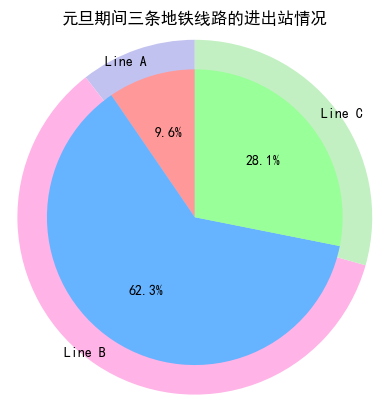

In [153]:
# 绘制元旦期间三条地铁线路的进出站百分比图

# 数据
labels = ['Line A', 'Line B', 'Line C']
sizes1 = [df3_A_0.shape[0], df3_B_0.shape[0], df3_C_0.shape[0]] 
sizes2 = [df3_A_1.shape[0], df3_B_1.shape[0], df3_C_1.shape[0]] 

# 绘制饼图1
plt.pie(sizes1, radius=1.2, colors=['#c2c2f0', '#ffb3e6', '#c2f0c2'], startangle=90)

# 绘制饼图2
plt.pie(sizes2, labels=labels, autopct='%1.1f%%', startangle=90, radius=1.0, colors=['#ff9999', '#66b3ff', '#99ff99'])

# 添加标题
plt.title('元旦期间三条地铁线路的进出站情况')

# 显示图形
plt.show()


In [112]:
# 选取周内两天作为对比：这里以 1月3日(周一) 和 1月5日（周三）为例，对三条线路情况进行分析

df4 = df[(df['date1'] == '2022-01-03') | (df['date1'] == '2022-01-05')]
df4 = df4.sample(n=19512, axis=0)
df4.shape

(19512, 10)

In [113]:
df4.sample(n=10).head()

,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
40269,2022-01-05 18:20:45,B,15,771,0,D36d10227afd37905310c3b53d6ac5f9f,3,2022-01-05,18:20:45,18
22368,2022-01-03 14:44:04,C,56,2678,0,Cd92e6a0b9f8f14c12df09d8be6c6b9eb,2,2022-01-03,14:44:04,14
43545,2022-01-05 15:30:25,B,9,447,0,Ab6e794f910df52f6f665e5b08079ae8d,0,2022-01-05,15:30:25,15
45957,2022-01-05 09:04:41,C,60,2830,1,C97c0b3fd7d2ff42fe3285843f79b89cf,2,2022-01-05,09:04:41,9
28682,2022-01-03 07:07:42,B,10,541,0,Dea7be7c1371600e427317ba3fcc42086,3,2022-01-03,07:07:42,7


In [114]:
# 计算三条线路的进出站情况

# 线路A
df4_A_0 = df4[(df4['lineID'] == 'A') & (df4['status'] == 0)]
df4_A_1 = df4[(df4['lineID'] == 'A') & (df4['status'] == 1)]

# 线路B
df4_B_0 = df4[(df4['lineID'] == 'B') & (df4['status'] == 0)]
df4_B_1 = df4[(df4['lineID'] == 'B') & (df4['status'] == 1)]

# 线路C
df4_C_0 = df4[(df4['lineID'] == 'C') & (df4['status'] == 0)]
df4_C_1 = df4[(df4['lineID'] == 'C') & (df4['status'] == 1)]

# 数值打印检测
# print(df4_A_1.shape[0], df4_A_0.shape[0])
# print(df4_B_1.shape[0], df4_B_0.shape[0])
# print(df4_C_1.shape[0], df4_C_0.shape[0])

In [115]:
# 选取周末两天作为对比：这里选择 1月7日(周六) 和 1月8日（周日）为例，对三条线路情况进行分析

df5 = df[(df['date1'] == '2022-01-07') | (df['date1'] == '2022-01-08')]
df5.shape

(19512, 10)

In [116]:
# 计算三条线路的进出站情况

# 线路A
df5_A_0 = df5[(df5['lineID'] == 'A') & (df5['status'] == 0)]
df5_A_1 = df5[(df5['lineID'] == 'A') & (df5['status'] == 1)]

# 线路B
df5_B_0 = df5[(df5['lineID'] == 'B') & (df5['status'] == 0)]
df5_B_1 = df5[(df5['lineID'] == 'B') & (df5['status'] == 1)]

# 线路C
df5_C_0 = df5[(df5['lineID'] == 'C') & (df5['status'] == 0)]
df5_C_1 = df5[(df5['lineID'] == 'C') & (df5['status'] == 1)]

# 数值打印检测
# print(df5_A_1.shape[0], df5_A_0.shape[0])
# print(df5_B_1.shape[0], df5_B_0.shape[0])
# print(df5_C_1.shape[0], df5_C_0.shape[0])

<font size=4 color=#0000dd>绘制横向柱状图</font>

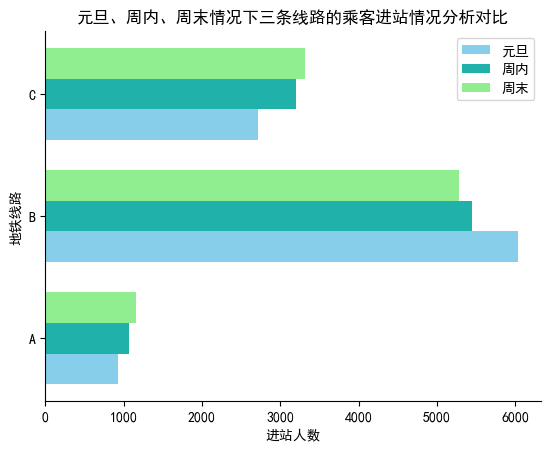

In [119]:
# 元旦(df3)、周内(df4)、周末(df5)情况下三条线路的乘客进站情况分析对比

import matplotlib.pyplot as plt
import numpy as np

# 数据
data = np.array([[df3_A_1.shape[0],df3_B_1.shape[0],df3_C_1.shape[0]],
                [df4_A_1.shape[0],df4_B_1.shape[0],df4_C_1.shape[0]],
                [df5_A_1.shape[0],df5_B_1.shape[0],df5_C_1.shape[0]]])

name = ["元旦","周内","周末"]

# 颜色
colors = ['#87CEEB', '#20B2AA', '#90EE90']

# 宽度
width = 0.25

# 绘图
fig, ax = plt.subplots()
for i in range(data.shape[0]):
    ax.barh(np.arange(data.shape[1]) + i*width, data[i], width, color=colors[i], label=name[i])
    
    
plt.title('元旦、周内、周末情况下三条线路的乘客进站情况分析对比')
    
# 坐标轴标签
ax.set_xlabel('进站人数')
ax.set_ylabel('地铁线路')
# 设置刻度
ax.set_yticks([0.25,1.25,2.25]) 
# 设置刻度标签
ax.set_yticklabels(['A','B','C']) 
# 图例
ax.legend()

# 美化
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

<font size=5> **小结** </font>

- 根据饼图结果可得，元旦期间，`地铁线路B` 的客流量占总体的 `60%` 左右；
- 根据条形图结果可得，可知周内期间 `地铁线路B` 高出节假日和周末大概`2000人` 左右
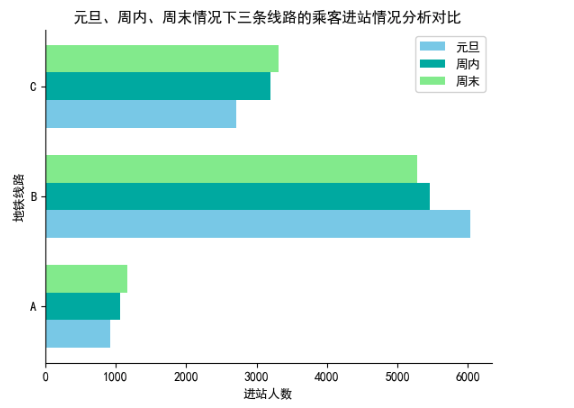

## 4.3 分析某一天的客流量情况

- 以 `2022-01-16` 当天的数据为例，分析各个时间段的进出站情况
- 假设早高峰是 `7:00-9:00`，晚高峰是 `17:00 - 20:00`，分析 `2022-01-16` 当天的早晚高峰情况。

<font size=4 color=#0000dd>将 data表中 `date1列`中所有`2022-01-16`这一天的数据提取出来，赋值给`表df6`</font>

In [120]:
df6 = df[(df['date1'] == '2022-01-16')]
print(df6.shape)
df6.head()

(9782, 10)


,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
150000,2022-01-16 08:41:08,A,78,3564,1,B0d2a6b10e410692ac1f36b459d449430,1,2022-01-16,08:41:08,8
150001,2022-01-16 07:25:29,C,50,2423,1,B70827b5074464c0f2b5fae86c6371a4a,1,2022-01-16,07:25:29,7
150002,2022-01-16 07:33:55,A,70,3241,1,Cf4bd46d57406241b4be2733674508cd6,2,2022-01-16,07:33:55,7
150003,2022-01-16 21:35:33,A,70,3238,0,Af0e13f70c4e5f7f18bafdedbd59a236d,0,2022-01-16,21:35:33,21
150004,2022-01-16 08:23:22,B,7,326,1,C499b2259a6090766005d52bc020ec71d,2,2022-01-16,08:23:22,8


In [121]:
# 对 df6 按 hours 这一列 升序排列

df6 = df6.sort_values(by='hours',ascending=True)
df6.head(10)

,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
151755,2022-01-16 07:20:11,C,35,1676,1,Ceeb1496b9a1121a37bace9e5ca3bd40e,2,2022-01-16,07:20:11,7
155373,2022-01-16 07:14:05,B,22,1149,1,Cb2bacfb7d8d70bbacdf2762d2e2ab20b,2,2022-01-16,07:14:05,7
154220,2022-01-16 07:55:15,C,62,2907,1,C0cfc2c112af61a6d02a0c4ba3fa409ad,2,2022-01-16,07:55:15,7
152456,2022-01-16 07:06:29,B,29,1434,1,B5fe8ccfafad38e38ab029cd3bd02a020,1,2022-01-16,07:06:29,7
155367,2022-01-16 07:12:11,C,53,2562,0,D54ae9d0a9d58331969c2a8eb994b3f2a,3,2022-01-16,07:12:11,7
157128,2022-01-16 07:33:56,C,46,2176,0,B093d2219b1c99dfae8decf491eb5a700,1,2022-01-16,07:33:56,7
158371,2022-01-16 07:49:42,B,33,1594,1,Dd2d64b0f78436ff24fa680c5ee559fc7,3,2022-01-16,07:49:42,7
152443,2022-01-16 07:56:44,C,61,2868,1,D9dc91b6106e8e64141202e06b4138929,3,2022-01-16,07:56:44,7
152438,2022-01-16 07:37:31,B,15,767,0,Bfc9bf825077b55d48895b5c8d3fa8c1f,1,2022-01-16,07:37:31,7
157122,2022-01-16 07:55:50,C,53,2566,1,C0c76cf4a9362dd5c1050342370a9c1a2,2,2022-01-16,07:55:50,7


In [122]:
# 线路 A 每小时乘客记录统计
df6_A = df6[df6['lineID'] == 'A']
df6_A['hours'].value_counts()

8     188
17    144
18     98
9      77
16     69
19     66
7      61
20     57
13     57
14     53
15     51
21     48
12     40
10     40
11     34
22     23
Name: hours, dtype: int64

<font size=4 color=#0000dd>按照`df6_A`的方法，筛选出线路B和线路C</font>

In [124]:
# 线路 B 每小时乘客记录统计
df6_B = df6[df6['lineID'] == 'B']
df6_B['hours'].value_counts()

8     724
18    512
17    503
7     437
9     366
19    329
16    312
15    308
13    294
14    289
20    277
12    277
11    263
10    261
21    211
22    136
Name: hours, dtype: int64

In [125]:
# 线路 C 每小时乘客记录统计
df6_C = df6[df6['lineID'] == 'C']
df6_C['hours'].value_counts()

8     494
17    347
18    331
7     271
9     227
19    202
12    153
20    152
16    149
21    137
10    134
13    129
14    126
15    124
11    109
22     92
Name: hours, dtype: int64

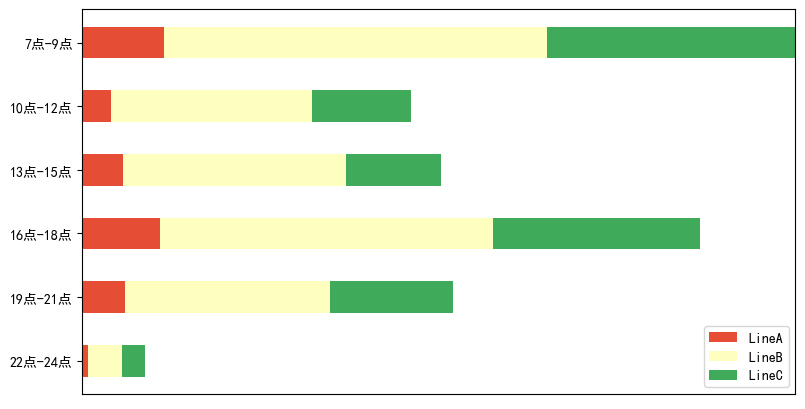

In [126]:
# 对线路A、B、C每个时间段进出站人数情况的可视化分析

# 数据
category_names = ['LineA', 'LineB', 'LineC']
results = {
    '7点-9点': [326, 1527, 992],
    '10点-12点': [114, 801, 396],
    '13点-15点': [161, 891, 379],
    '16点-18点': [311, 1327, 827],
    '19点-21点': [171, 817, 491],
    '22点-24点': [23, 136, 92]
}

# 绘图
def survey(results, category_names):

    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)
#        ax.text(color, colname, labels[i], ha='center')
#
#        r, g, b, _ = color
#        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
#        ax.bar_label(rects, label_type='center', color=text_color)
#    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
#                loc='lower left', fontsize='small')

    return fig, ax

survey(results, category_names)
plt.legend()
plt.show()

<font size=5> **小结** </font>

- 根据上述图示结果可得，`2022-01-16` 这一天中，7点到9点以及16点到18点，各个线路的乘客流量都比较大，值得注意的是压力最大的线路仍然是线路B。

## 4.4  早晚高峰情况分析



<font size=4 color=#0000dd>根据`表df6`中的`hours列`筛选出`7点至9点`的所有数据</font>

In [127]:
# 早高峰

MornPeak= df6[(df6['hours'] >= 7) & (df6['hours'] <= 9)]
MornPeak.shape

(2845, 10)

In [128]:
MornPeak.sample(n=10)

,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
155928,2022-01-16 09:27:31,B,15,771,0,Deee9c8249f58053417894a906a3decd4,3,2022-01-16,09:27:31,9
151974,2022-01-16 08:23:41,C,42,1948,1,Bbf07fb3d70f3c63d8931880b4a222721,1,2022-01-16,08:23:41,8
158636,2022-01-16 08:05:49,A,68,3166,1,Cb5efec821705ab73e0c7f4e2993d7206,2,2022-01-16,08:05:49,8
159417,2022-01-16 08:50:24,B,8,383,0,C6220df57debf9268adc2e3005590b7b8,2,2022-01-16,08:50:24,8
156512,2022-01-16 07:10:21,B,15,766,0,Bad7f14db6296e4dbadf5da987ff686f5,1,2022-01-16,07:10:21,7
158555,2022-01-16 08:33:08,C,65,3030,1,A2e711918da1dcf751e2d06310b70dfe4,0,2022-01-16,08:33:08,8
159178,2022-01-16 07:10:11,C,49,2353,0,Ad4ec812209f83e043eec5c1f648f3755,0,2022-01-16,07:10:11,7
155877,2022-01-16 08:17:46,C,37,1760,1,Bb04169f3c1d78823f9056f072cf54b0d,1,2022-01-16,08:17:46,8
150186,2022-01-16 08:38:28,A,77,3526,0,A9e755f731b2712e70ed8591d63363f77,0,2022-01-16,08:38:28,8
152137,2022-01-16 08:19:31,B,6,286,1,B6ff82575f30ae8f861747b6507203da6,1,2022-01-16,08:19:31,8


In [129]:
# 提取早高峰线路A、B、C进出站数据
def MornExtract(name):
    
    a_1 = MornPeak[(MornPeak['lineID'] == name) & (MornPeak['status'] == 1.0)]
    a_0 = MornPeak[(MornPeak['lineID'] == name) & (MornPeak['status'] == 0.0)]
    
    return a_1, a_0 

lineA_1, lineA_0 = MornExtract('A')
lineB_1, lineB_0 = MornExtract('B')
lineC_1, lineC_0 = MornExtract('C')

# print(lineA_1.shape[0], lineA_0.shape[0])
# print(lineB_1.shape[0], lineB_0.shape[0])
# print(lineC_1.shape[0], lineC_0.shape[0])

In [130]:
# 创建新表
columns = ['lineID', 'status_1', 'status_0']
values = [['A',lineA_1.shape[0], lineA_0.shape[0]], ['B', lineB_1.shape[0], lineB_0.shape[0]], ['C', lineC_1.shape[0], lineC_0.shape[0]]]
NMPeak = pd.DataFrame(data=values, index=None, columns=columns)
NMPeak.head()

,lineID,status_1,status_0
0,A,123,203
1,B,814,713
2,C,549,443


In [131]:
# 晚高峰
EvenPeak= df6[(df6['hours'] >= 17) & (df6['hours'] <= 20)]
EvenPeak.shape

(3018, 10)

In [132]:
EvenPeak.sample(n=10)

,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
154849,2022-01-16 18:24:34,B,9,459,1,Bf185471a0b1c7f5983b10b141d9434c8,1,2022-01-16,18:24:34,18
153993,2022-01-16 17:55:01,C,52,2516,0,Ad9e59091b337bf3ce2ca353af02e290f,0,2022-01-16,17:55:01,17
158032,2022-01-16 18:34:29,C,35,1673,0,C973b3e0df13185363549a69901468a40,2,2022-01-16,18:34:29,18
154370,2022-01-16 17:10:51,C,52,2532,1,A086409a75a21141d9ec9593dd055236f,0,2022-01-16,17:10:51,17
155345,2022-01-16 17:59:06,C,46,2174,1,C5bcd34003d14dc321de38b63177d748c,2,2022-01-16,17:59:06,17
155959,2022-01-16 17:23:07,B,1,42,0,A94de219039fc41582734d331e69e1a0a,0,2022-01-16,17:23:07,17
150504,2022-01-16 20:42:09,C,58,2745,1,Beceee837fd1ff34675743da9ee097aab,1,2022-01-16,20:42:09,20
154910,2022-01-16 19:25:26,B,15,784,0,Decb1e1aaa5fb482402c757808e71e7c2,3,2022-01-16,19:25:26,19
155616,2022-01-16 19:45:08,A,75,3409,1,Cd24bea5abe948c7de4043d7f8eb2ed04,2,2022-01-16,19:45:08,19
150774,2022-01-16 18:24:42,B,18,976,1,A818cd91cbce18967be924737f9c17ee6,0,2022-01-16,18:24:42,18


<font size=4 color=#0000dd>根据早高峰提取函数`def MornExtract(name):` 完善晚高峰提取函数</font>

In [134]:
# 提取晚高峰线路A、B、C进出站数据

def EvenExtract(name):
    
    a_1 = EvenPeak[(EvenPeak['lineID'] == name) & (EvenPeak['status'] == 1.0)]
    a_0 = EvenPeak[(EvenPeak['lineID'] == name) & (EvenPeak['status'] == 0.0)]
    
    return a_1, a_0 

E_lineA_1, E_lineA_0 = EvenExtract('A')
E_lineB_1, E_lineB_0 = EvenExtract('B')
E_lineC_1, E_lineC_0 = EvenExtract('C')

# print(E_lineA_1.shape[0], E_lineA_0.shape[0])
# print(E_lineB_1.shape[0], E_lineB_0.shape[0])
# print(E_lineC_1.shape[0], E_lineC_0.shape[0])

In [135]:
# 创建新表
columns = ['lineID', 'status_1', 'status_0']
values = [['A',E_lineA_1.shape[0], E_lineA_0.shape[0]], ['B', E_lineB_1.shape[0], E_lineB_0.shape[0]], ['C', E_lineC_1.shape[0], E_lineC_0.shape[0]]]
NEPeak = pd.DataFrame(data=values, index=None, columns=columns)
NEPeak.head()

,lineID,status_1,status_0
0,A,236,129
1,B,745,876
2,C,493,539


<font size=4 color=#0000dd>绘制堆叠柱状图，绘制子图</font>

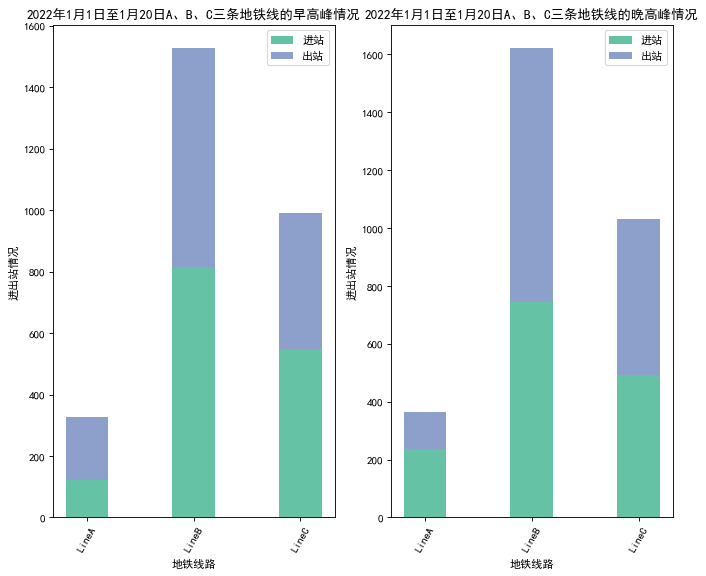

In [154]:
# 设置图像大小为（10,10）
fig = plt.figure(figsize=(10, 8), dpi=80)

## 早高峰图
plt.subplot(1, 2, 1)
plt.bar(NMPeak['lineID'], NMPeak['status_1'], align='center',width=0.4, color='#66c2a5', tick_label='Line'+ NMPeak['lineID'], label='进站')
plt.bar(NMPeak['lineID'], NMPeak['status_0'], width=0.4, bottom=NMPeak['status_1'], color='#8da0cb', label='出站')

plt.title("2022年1月1日至1月20日A、B、C三条地铁线的早高峰情况")
# 设置x轴标签
plt.xlabel('地铁线路')
# 设置y轴标签
plt.ylabel('进出站情况')
# 刻度标签倾斜60度
plt.xticks(rotation=60)
# 显示图例
plt.legend()  


## 晚高峰图
plt.subplot(1, 2, 2)

# 颜色
colors = ['#FF7F50', '#0000FF']

# 绘图
plt.bar(NEPeak['lineID'], NEPeak['status_1'], align='center',width=0.4, color='#66c2a5', tick_label='Line'+ NEPeak['lineID'], label='进站')
plt.bar(NEPeak['lineID'], NEPeak['status_0'], width=0.4, bottom=NEPeak['status_1'], color='#8da0cb', label='出站')


plt.title("2022年1月1日至1月20日A、B、C三条地铁线的晚高峰情况")

# 设置x轴标签
plt.xlabel('地铁线路')
# 设置y轴标签
plt.ylabel('进出站情况')
# 刻度标签倾斜60度
plt.xticks(rotation=60)
# 显示图例
plt.legend()  
plt.show()


<font size=5> **小结** </font>

- 根据上述图示结果可以清晰的看到 `2022-01-16` 这一天早晚高峰各条线路的进出站情况，压力最大的线路是`B`，其次是线路 `C`, 压力最小的线路是 `A`